# Введение
Подключение необходимых библиотек

In [232]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [185]:
events_data = pd.read_csv("event_data_train.csv")
submissions = pd.read_csv("submissions_data_train.csv")

In [186]:
events_data.head()

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632


In [187]:
submissions.head()

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853


## преобразование исходных данных

In [188]:
#коолонка для даты (до секнуд)
events_data["date"] = pd.to_datetime(events_data["timestamp"],unit='s')

#добавить колонку даты до дня
events_data['day']=events_data['date'].dt.date 

#те же операции с submission
submissions["date"] = pd.to_datetime(submissions['timestamp'],unit="s")
submissions["day"] = submissions["date"].dt.date

# Анализ данных

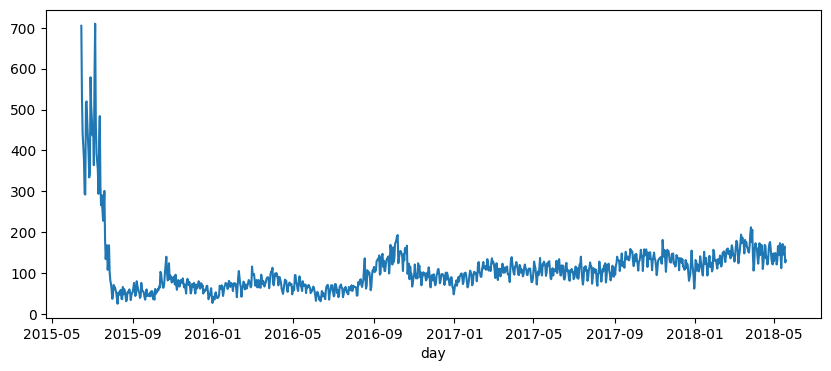

In [189]:
fig,ax = plt.subplots(figsize=(10,4))

day_users = events_data.groupby("day").user_id.nunique().plot(ax = ax)

## Подсчет участников с исползованием pivot таблиц

[]

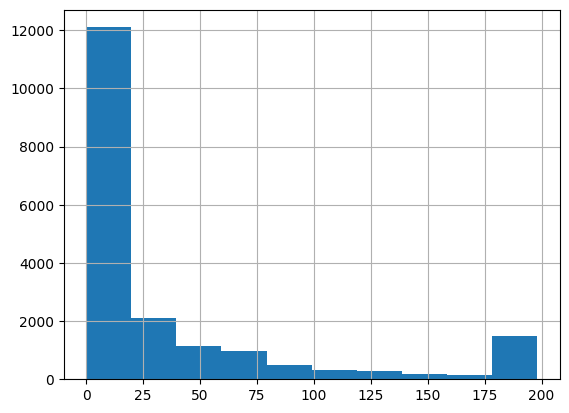

In [190]:
fig, ax = plt.subplots()
ax = events_data.pivot_table(index="user_id",columns="action",values="step_id",aggfunc="count",fill_value=0).discovered.hist()

ax.plot()

In [191]:
users_event_data = events_data.pivot_table(index='user_id',
                                           columns="action",
                                           values="step_id",
                                           fill_value=0,
                                           aggfunc="count").reset_index()
users_event_data.head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1


In [192]:
users_score = submissions.pivot_table(index="user_id", 
                             columns="submission_status", 
                             values="step_id", 
                             aggfunc="count", 
                             fill_value=0).reset_index()

users_score.head()


submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


## Определение участников "выпавших из курса"

In [193]:
date_gap =( events_data[["user_id","day","timestamp"]]
    .drop_duplicates(subset=["user_id","day"])
    .groupby("user_id")["timestamp"]
    .agg(list)
    .transform(np.diff)
)
date_gap.values

array([array([], dtype=int64), array([4843602]),
       array([6899249,  182484,   93710, 2768870,  171400,   78712]), ...,
       array([   86128,   136759,    94899,  1422583, 14347289,   505061,
                 98252,    57019])                                       ,
       array([1567990]), array([], dtype=int64)],
      shape=(19234,), dtype=object)

In [194]:
date_gap = pd.Series(np.concatenate(date_gap.values, axis = 0)) / (24*60*60)

<Axes: >

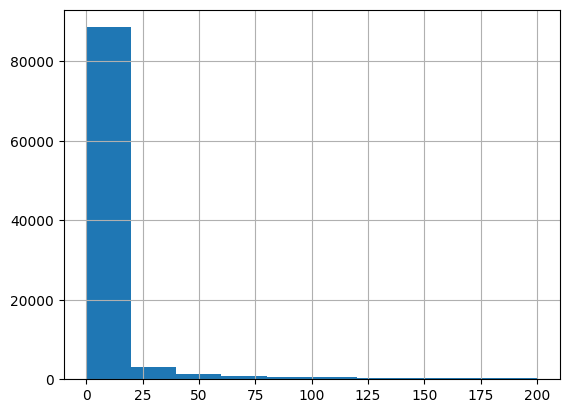

In [195]:
fig, ax = plt.subplots()

date_gap[date_gap<200].hist(ax=ax)


In [196]:
date_gap.quantile(0.90)

np.float64(18.325995370370403)

In [197]:
drop_out_timestamp = date_gap.quantile(0.90) *24*60*60
now = events_data.timestamp.max()

In [198]:
#добавить колонку последнего входа пользователя
users_data = events_data.groupby("user_id", as_index=False).agg({"timestamp":"max"}).rename(columns={"timestamp":"last_timestamp"})

#отранжировать данные
#последнее действие пользователя не должно превышать порог
users_data["is_gone"] = (now - users_data["last_timestamp"]) > drop_out_timestamp

users_data = (users_data.drop("last_timestamp",axis=1) #убираем техническую колонку с временем последнего действия
    .merge(users_score,how="outer") #добавляем данные по практическим заданиям (количество правильных/неправильных попыток)
    .fillna(0)) #некоторые пользователи не дошли до правктики, заполняем пропуски 0

#добавляем данные о действиях участника курса
users_data = users_data.merge(users_event_data, how="outer") 

#сертификат о прохождении курса выдается с 175 пройденных точек
users_data["is_passed"] = users_data.passed > 175

In [199]:
users_data.groupby("is_passed").count()["user_id"]

is_passed
False    17844
True      1390
Name: user_id, dtype: int64

# Выборка тренировочных данных
Пусть модель будет предсказывать вероятность оттока студента на 3-м дне обучения. Отберем все данные для создания тренировочного датасета

In [200]:
#3 дня в секундах
timestamp_user_treshold = 3*24*60*60

## Фильтрация студентов
отберем данные для каждого польщзователя на первых 3-х днях обучения

In [201]:
#Вспомогательная колонка первого действия на курсе для кждого пользователя
user_min_timestamp = events_data.groupby("user_id", as_index=False).agg({"timestamp":"min"}).rename(columns={"timestamp":"min_timestamp"})

#К первому действию добавляем 3 дня и получаем порог отбора по времени
user_threshold = user_min_timestamp.min_timestamp + timestamp_user_treshold
#Переносим его в новую колонку, сохраняя индекс пользователя
user_min_timestamp["user_threshold"] = user_min_timestamp.user_id.astype(str) +"_"+ user_threshold.astype(str)

In [202]:
user_min_timestamp.head()

,user_id,min_timestamp,user_threshold
0,1,1472827464,1_1473086664
1,2,1514383364,2_1514642564
2,3,1434358476,3_1434617676
3,5,1466156809,5_1466416009
4,7,1521634660,7_1521893860


In [203]:
#Колонка индекса пользователя + "_" + время на текущим степе (для корректного сравнения)
events_data["user_timestamp"] = events_data.user_id.astype(str) +"_"+ events_data.timestamp.astype(str)

#перезаписыаем датасет с новыми колонками
events_data = events_data.merge(user_min_timestamp.drop("min_timestamp", axis=1), #игнорируем вспомогательную переменную
                                 on="user_id",how="outer")

#фильтруем данные каждого степа по устаноленному порогу
events_train = events_data[events_data.user_timestamp <= events_data.user_threshold]


#повторяем для 2-го датасета по практике
submissions["user_timestamp"] = submissions.user_id.astype(str) +"_"+ submissions.timestamp.astype(str)
submissions = submissions.merge(user_min_timestamp.drop("min_timestamp", axis=1), on="user_id",how="outer")
submissions_train = submissions[submissions.user_timestamp <= submissions.user_threshold]

In [204]:
events_train.head()

,step_id,timestamp,action,user_id,date,day,user_timestamp,user_threshold
0,31981,1472827464,viewed,1,2016-09-02 14:44:24,2016-09-02,1_1472827464,1_1473086664
1,31981,1472827464,discovered,1,2016-09-02 14:44:24,2016-09-02,1_1472827464,1_1473086664
2,32815,1514383364,discovered,2,2017-12-27 14:02:44,2017-12-27,2_1514383364,2_1514642564
3,32815,1514383364,viewed,2,2017-12-27 14:02:44,2017-12-27,2_1514383364,2_1514642564
4,32815,1514383364,passed,2,2017-12-27 14:02:44,2017-12-27,2_1514383364,2_1514642564


## Формируем готовый датасет обучения

In [275]:
X = (submissions_train.groupby("user_id",as_index=False)
    .agg({"step_id":"nunique","day":"nunique"}) #получаем количество уникальных степов и количество потраченных дней по студенту
    .rename(columns={"step_id":"steps_tried","day":"practice_days"})) #переименовываем колонки

In [276]:
#добавим данные о практических заданиях
X = X.merge(submissions_train.pivot_table(
    index="user_id", #данные отбираем по каждому студенту
    values="step_id", #агрегируем по степам 
    columns="submission_status", #разделяем статусы верно/неверно по колонкам
    aggfunc="count", #общее количество правильных/неправильны решений
    fill_value=0).reset_index(), on="user_id",how="outer") #заполняем пропуски для тех, кто ничего не решал


#Добавляем колонку показателя точности ответа
X["answer_accuracy"] = X.correct / (X.correct + X.wrong)

In [277]:
#То же самое с датасетом действий
X = X.merge(events_train.pivot_table(index="user_id", #для кадого студента
                                    values="step_id", #по каждому степу
                                    columns="action", #разбиение по вариантам действий
                                    fill_value=0, aggfunc="count").reset_index(),on="user_id",how="outer")

In [278]:
#все пропуски заполняем 0 по умолчанию
X = X.fillna(0)

#добавляем данные о прохождении / завале курса
X = X.merge(users_data[['user_id',"is_gone","is_passed"]],on="user_id",how="outer")

In [279]:
#фильтруем пользователей, которые еще не прошли курс и при этом активно его решают
X = X[X.is_gone | X.is_passed]

#выбрасываем вспомогательную переменную
X = X.drop("is_gone", axis=1)

In [280]:
#индексы не должны учасвствовать в исследовании
X = X.set_index("user_id")

#переменная viewed уже содержит необходимые данные, остальные излишни
X = X.drop(["discovered","passed","started_attempt"],axis=1)

X.head()

,steps_tried,practice_days,correct,wrong,answer_accuracy,viewed,is_passed
user_id,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,1,False
2,2.0,1.0,2.0,0.0,1.0,9,False
3,4.0,1.0,4.0,4.0,0.5,20,False
5,0.0,0.0,0.0,0.0,0.0,1,False
7,0.0,0.0,0.0,0.0,0.0,1,False


В текущей фильтрации пользователи имеют 100% точность, но это не отражает способность решать курс (люди решают мало степов и получают больую точность)

<Axes: xlabel='answer_accuracy', ylabel='Count'>

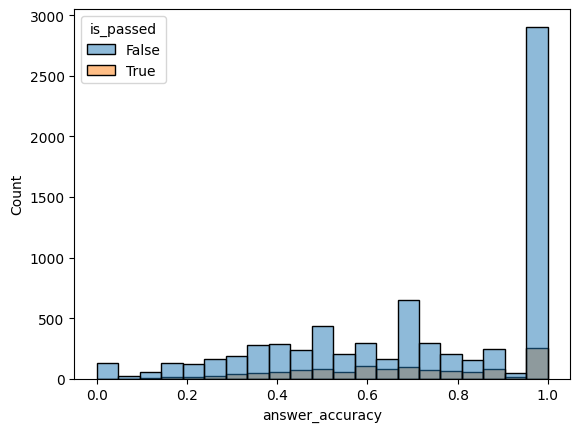

In [281]:
#люди с пропусками загрязняют график, отфильтруем их
sns.histplot(X[X.steps_tried >0],x="answer_accuracy", hue="is_passed")

In [283]:
answer_accurancy_normalized = (X.correct / (X.correct + X.wrong)) * X.steps_tried
answer_accurancy_normalized = answer_accurancy_normalized.fillna(0)

*мысли на позже. Попробовать использовать уровень доверительного интервала как параметр нормализаии*

<Axes: xlabel='steps_tried', ylabel='Count'>

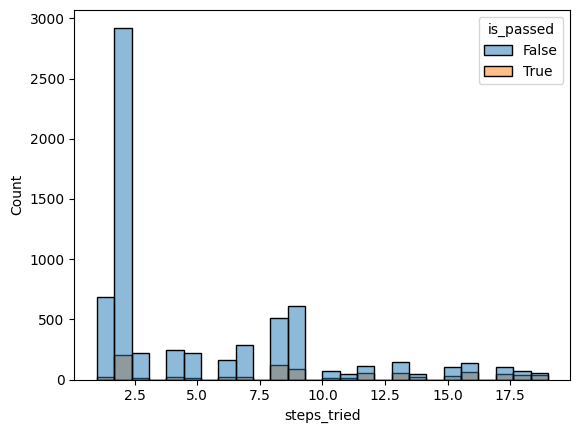

In [297]:
sns.histplot(X[(X.steps_tried >0) & (X.steps_tried <20)],x="steps_tried",hue="is_passed")

In [214]:
X["weighted_score"] =answer_accurancy_normalized

<Axes: xlabel='weighted_score', ylabel='Count'>

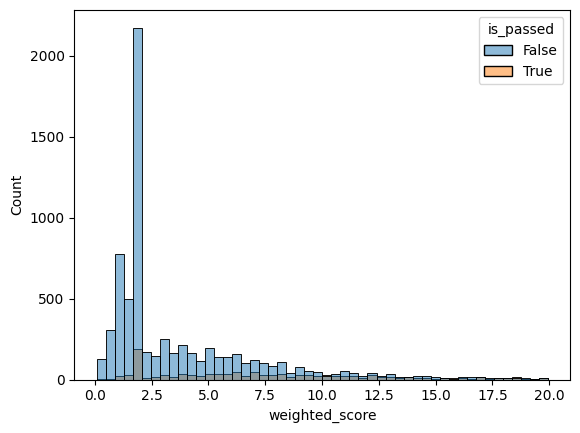

In [215]:
sns.histplot(X[(X.weighted_score>0) & (X.weighted_score <20)], x="weighted_score", hue="is_passed")

# Модель
Разработка модели линейной регрессии и дерева решений на данных

In [243]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

## Дерево-классификатор

In [244]:
#дерево классификатор
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier

In [260]:
#не включаем экспериментальную переменую ROC=0.55
#X_df = X.drop(["is_passed","weighted_score"], axis=1)

X_df = X.drop(["is_passed","steps_tried","answer_accuracy","correct","wrong"], axis=1)

y_df = X["is_passed"]

In [261]:
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df,test_size=0.25)

In [262]:
parameters = {"max_depth":range(1,20),"min_samples_split":range(2,10), "min_samples_leaf":range(2,10)}

clf = DecisionTreeClassifier()

search = GridSearchCV(clf,param_grid=parameters)
search.fit(X_train,y_train)

best_tree = search.best_estimator_

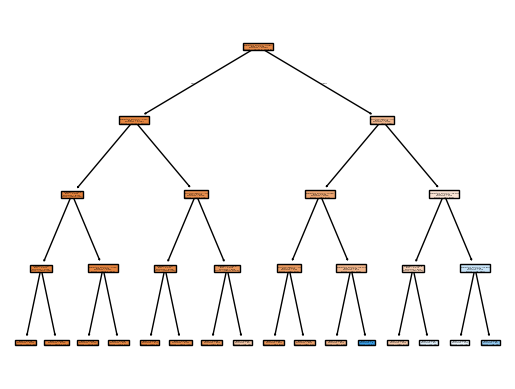

In [263]:
plot_tree(best_tree,feature_names=X_train.columns, filled=True)
plt.show()

## ROC кривая для дерева решений

In [264]:
predicted = best_tree.predict(X_test)

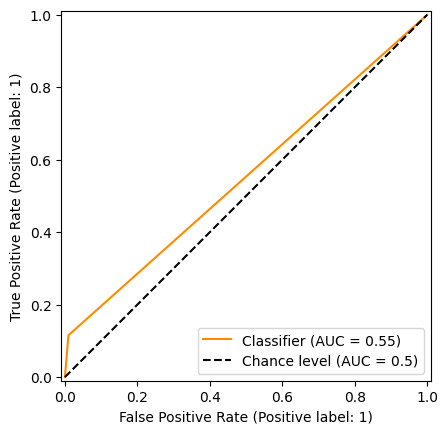

In [265]:
roc_curve = metrics.RocCurveDisplay.from_predictions(y_test, predicted, color="darkorange",plot_chance_level=True,)
